In [1]:
# CELL 1
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, jaccard_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random


In [2]:
# CELL 2
# Define variables
img_height = 512
img_width = 128
channels = 3
num_classes = 3  # Updated number of classes (0 for background, 1 for bone, 2 for cancer)

batch_size = 4   # Increased batch size for stability
epochs = 20      # Increased epochs for better training

# Paths to the datasets
image_dir = r"/kaggle/input/whole-body-bone-scan-with-mask-scenario-2/Whole Body Bone Scan ANT"
mask_dir = r"/kaggle/input/whole-body-bone-scan-with-mask-scenario-2/MaskV3"

# Directory to save model checkpoints
checkpoint_dir = r"/kaggle/working/"
os.makedirs(checkpoint_dir, exist_ok=True)


In [3]:
# CELL 3
images = []
masks = []

# Get list of image files
image_files = [
    f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')
]

# Load images and corresponding masks
for file in image_files:
    # Load and resize image
    image_path = os.path.join(image_dir, file)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read image {file}, skipping.")
        continue
    image = cv2.resize(image, (img_width, img_height))
    image = image / 255.0  # Normalize image

    # Construct mask filename
    base_filename = os.path.splitext(file)[0]
    mask_filename = base_filename + '_colored_mask.npy'  # Adjust based on your mask filename pattern
    mask_path = os.path.join(mask_dir, mask_filename)
    if not os.path.exists(mask_path):
        print(f"Mask not found for image {file}, skipping.")
        continue

    # Load and resize mask
    mask = np.load(mask_path)
    mask = cv2.resize(mask, (img_width, img_height), interpolation=cv2.INTER_NEAREST)

    # Check unique values in mask
    unique_values = np.unique(mask)
    print(f"Unique values in {mask_filename}: {unique_values}")
    if not np.all(np.isin(unique_values, [0, 1, 2])):  # Ensure values are 0, 1, 2 for 3 classes
        print(f"Unexpected values in mask for {file}, skipping.")
        continue

    # Convert mask to one-hot encoding (for 3 classes)
    mask_one_hot = np.zeros((img_height, img_width, num_classes), dtype=np.uint8)
    for i in range(num_classes):
        mask_one_hot[..., i] = (mask == i).astype(np.uint8)

    images.append(image)
    masks.append(mask_one_hot)

# Convert lists to NumPy arrays
images = np.array(images)
masks = np.array(masks)

# Print the shapes
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)


Unique values in 1269_colored_mask.npy: [0 1 2]
Unique values in 623_colored_mask.npy: [0 1]
Unique values in 2193_colored_mask.npy: [0 1]
Unique values in 2008_colored_mask.npy: [0 1]
Unique values in 2081_colored_mask.npy: [0 1 2]
Unique values in 3138_colored_mask.npy: [0 1 2]
Unique values in 764_colored_mask.npy: [0 1]
Unique values in 1700_colored_mask.npy: [0 1]
Unique values in 1786_colored_mask.npy: [0 1]
Unique values in 2907_colored_mask.npy: [0 1]
Unique values in 1075_colored_mask.npy: [0 1]
Unique values in 2863_colored_mask.npy: [0 1 2]
Unique values in 771_colored_mask.npy: [0 1]
Unique values in 208_colored_mask.npy: [0 1]
Unique values in 2628_colored_mask.npy: [0 1 2]
Unique values in 820_colored_mask.npy: [0 1]
Unique values in 1789_colored_mask.npy: [0 1]
Unique values in 473_colored_mask.npy: [0 1 2]
Unique values in 1792_colored_mask.npy: [0 1]
Unique values in 2936_colored_mask.npy: [0 1 2]
Unique values in 2029_colored_mask.npy: [0 1 2]
Unique values in 1411_co

In [4]:
# CELL 4
# Split data into training, validation, and test sets
X_temp, X_test, Y_temp, Y_test = train_test_split(
    images, masks, test_size=0.1, random_state=42
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp, test_size=0.2, random_state=42
)

# Print dataset shapes
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (2104, 512, 128, 3)
Y_train shape: (2104, 512, 128, 3)
X_val shape: (527, 512, 128, 3)
Y_val shape: (527, 512, 128, 3)
X_test shape: (293, 512, 128, 3)
Y_test shape: (293, 512, 128, 3)


In [5]:
# CELL 5
# Compute class weights (adjust for 3 classes)
from sklearn.utils import class_weight

# Flatten masks to compute class weights
all_masks_flat = np.argmax(Y_train, axis=-1).flatten()
unique_classes, counts = np.unique(all_masks_flat, return_counts=True)
class_distribution = dict(zip(unique_classes, counts))
print("Class distribution in training masks:", class_distribution)

# Manually adjust class weights to emphasize minority classes
class_weights = np.array([0.5, 1.0, 5.0])  # Emphasize class 2 (cancer) more
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Adjusted Class Weights:", class_weights_dict)



Class distribution in training masks: {0: 110055489, 1: 27736882, 2: 95373}
Adjusted Class Weights: {0: 0.5, 1: 1.0, 2: 5.0}


In [6]:
# CELL 6
def focal_loss(gamma=2., alpha=class_weights):
    alpha = K.constant(alpha, dtype=tf.float32)
    gamma = float(gamma)

    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=-1)

    return focal_loss_fixed

def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    smooth = 1e-6
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def combined_loss(y_true, y_pred):
    return focal_loss()(y_true, y_pred) + dice_loss(y_true, y_pred)

loss_function = combined_loss


In [7]:
# CELL 7
# Updated model for 3 classes (0: background, 1: bone, 2: cancer)

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def unetplusplus(input_size=(img_height, img_width, channels), num_classes=3):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(c5)
    c5 = BatchNormalization()(c5)
    
    # Decoder with Deep Supervision
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)
    d6 = Conv2D(num_classes, (1, 1), activation='softmax')(c6)  # Deep Supervision Output 1
    d6_up = UpSampling2D(size=(8, 8), interpolation='bilinear', name='output_d6')(d6)  # Upsample to input size

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)
    d7 = Conv2D(num_classes, (1, 1), activation='softmax')(c7)  # Deep Supervision Output 2
    d7_up = UpSampling2D(size=(4, 4), interpolation='bilinear', name='output_d7')(d7)  # Upsample to input size

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)
    d8 = Conv2D(num_classes, (1, 1), activation='softmax')(c8)  # Deep Supervision Output 3
    d8_up = UpSampling2D(size=(2, 2), interpolation='bilinear', name='output_d8')(d8)  # Upsample to input size

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = BatchNormalization()(c9)
    d9 = Conv2D(num_classes, (1, 1), activation='softmax', name='output_d9')(c9)  # Deep Supervision Output 4

    # Final Output
    outputs = Conv2D(num_classes, (1, 1), activation='softmax', name='final_output')(c9)

    model = Model(inputs=[inputs], outputs=[outputs, d6_up, d7_up, d8_up, d9])
    return model

# Build the model
model = unetplusplus(num_classes=3)  # Now we have 3 classes: 0, 1, 2
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 128,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 64,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 64,   │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 64,   │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 64,   │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 64,   │    147,584 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 64,   │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 32,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 32,   │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 32,   │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 32,   │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 32,   │    590,080 │ dropout_2[0][0] 

 Total params: 31,058,319 (118.48 MB)

 Trainable params: 31,046,543 (118.43 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K

optimizer = Adam(learning_rate=1e-4)  # Starting with a low learning rate

# Implement IoU metric
def iou_metric(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = K.argmax(y_true, axis=-1)
    intersection = K.sum(K.cast(y_true * y_pred, 'float32'))
    union = K.sum(K.cast(y_true + y_pred, 'float32')) - intersection
    return intersection / (union + K.epsilon())

# Compile the model
model.compile(
    optimizer=optimizer,
    loss={
        'final_output': loss_function,
        'output_d6': loss_function,
        'output_d7': loss_function,
        'output_d8': loss_function,
        'output_d9': loss_function
    },
    loss_weights={
        'final_output': 1.0,
        'output_d6': 0.8,
        'output_d7': 0.6,
        'output_d8': 0.4,
        'output_d9': 0.2
    },
    metrics={
        'final_output': ['accuracy', iou_metric],
        'output_d6': 'accuracy',
        'output_d7': 'accuracy',
        'output_d8': 'accuracy',
        'output_d9': 'accuracy'
    }
)

# Learning Rate Scheduler Callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_final_output_loss',  # Monitor validation loss of the final output
    factor=0.5,  # Reduce the learning rate by a factor of 0.5
    patience=5,  # Wait 5 epochs before reducing the learning rate
    verbose=1,  # Print a message when the learning rate is reduced
    min_lr=1e-6  # Lower bound for the learning rate
)


In [9]:
# CELL 9
from tensorflow.keras.callbacks import ModelCheckpoint
import os

# Ensure that checkpoint_dir is defined
checkpoint_dir = r"/kaggle/working/"
os.makedirs(checkpoint_dir, exist_ok=True)

# Setup model checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "unetplusplus_best.weights.h5"),
    save_weights_only=True,
    save_best_only=True,  # Save weights when the model improves
    monitor='val_loss',  # Monitor the validation loss (you can adjust if needed)
    mode='min',  # Save when the loss decreases (minimizing loss)
    verbose=1
)


In [10]:
# CELL 10
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Early stopping callback to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_final_output_loss',
    patience=10,  # Increased patience due to data augmentation
    mode='min',
    restore_best_weights=True
)

# Prepare the targets for each output
Y_train_targets = {
    'final_output': Y_train,
    'output_d6': Y_train,
    'output_d7': Y_train,
    'output_d8': Y_train,
    'output_d9': Y_train
}

Y_val_targets = {
    'final_output': Y_val,
    'output_d6': Y_val,
    'output_d7': Y_val,
    'output_d8': Y_val,
    'output_d9': Y_val
}

# Data Augmentation
data_gen_args = dict(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the flow methods
seed = 42
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(Y_train, augment=True, seed=seed)

# Create generators
image_generator = image_datagen.flow(X_train, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(Y_train, batch_size=batch_size, seed=seed)

# Create custom generator function
def create_generator(image_gen, mask_gen):
    while True:
        X = next(image_gen)
        Y = next(mask_gen)
        Y_targets = {
            'final_output': Y,
            'output_d6': Y,
            'output_d7': Y,
            'output_d8': Y,
            'output_d9': Y
        }
        yield X, Y_targets

# Create train and validation generators
train_generator = create_generator(image_generator, mask_generator)

# Validation data generator (without augmentation)
val_image_datagen = ImageDataGenerator()
val_mask_datagen = ImageDataGenerator()

val_image_generator = val_image_datagen.flow(X_val, batch_size=batch_size, seed=seed, shuffle=False)
val_mask_generator = val_mask_datagen.flow(Y_val, batch_size=batch_size, seed=seed, shuffle=False)

val_generator = create_generator(val_image_generator, val_mask_generator)

# Adjust steps per epoch
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

# Training with EarlyStopping and ModelCheckpoint
try:
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_generator,
        validation_steps=validation_steps,
        epochs=epochs,
        callbacks=[checkpoint_callback, early_stopping, reduce_lr],  # Use your callbacks here
        verbose=1
    )
    # Save the model after successful training
    model.save(os.path.join(checkpoint_dir, "unetplusplus_final.h5"))
    print("Training completed. Model saved to disk.")
except KeyboardInterrupt:
    print("Training interrupted. Saving model.")
    model.save(os.path.join(checkpoint_dir, "unetplusplus_interrupted.h5"))
    print("Model saved.")


Epoch 1/20


I0000 00:00:1732867822.622964     372 service.cc:145] XLA service 0x7f0d94048390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732867822.623015     372 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732867822.623019     372 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732867873.636629     372 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - final_output_accuracy: 0.8958 - final_output_iou_metric: 0.6817 - loss: 1.1399 - output_d6_accuracy: 0.9171 - output_d7_accuracy: 0.9294 - output_d8_accuracy: 0.9191 - output_d9_accuracy: 0.8583
Epoch 1: val_loss improved from inf to 1.26829, saving model to /kaggle/working/unetplusplus_best.weights.h5
526/526 ━━━━━━━━━━━━━━━━━━━━ 228s 309ms/step - final_output_accuracy: 0.8959 - final_output_iou_metric: 0.6819 - loss: 1.1394 - output_d6_accuracy: 0.9171 - output_d7_accuracy: 0.9294 - output_d8_accuracy: 0.9192 - output_d9_accuracy: 0.8584 - val_final_output_accuracy: 0.8638 - val_final_output_iou_metric: 0.5940 - val_loss: 1.2683 - val_output_d6_accuracy: 0.8609 - val_output_d7_accuracy: 0.8083 - val_output_d8_accuracy: 0.8017 - val_output_d9_accuracy: 0.8440 - learning_rate: 1.0000e-04
Epoch 2/20


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_final_output_loss` which is not available. Available metrics are: final_output_accuracy,final_output_iou_metric,loss,output_d6_accuracy,output_d7_accuracy,output_d8_accuracy,output_d9_accuracy,val_final_output_accuracy,val_final_output_iou_metric,val_loss,val_output_d6_accuracy,val_output_d7_accuracy,val_output_d8_accuracy,val_output_d9_accuracy
  current = self.get_monitor_value(logs)
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_final_output_loss` which is not available. Available metrics are: final_output_accuracy,final_output_iou_metric,loss,output_d6_accuracy,output_d7_accuracy,output_d8_accuracy,output_d9_accuracy,val_final_output_accuracy,val_final_output_iou_metric,val_loss,val_output_d6_accuracy,val_output_d7_accuracy,val_output_d8_accuracy,

526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - final_output_accuracy: 0.9613 - final_output_iou_metric: 0.8117 - loss: 0.6278 - output_d6_accuracy: 0.9445 - output_d7_accuracy: 0.9556 - output_d8_accuracy: 0.9599 - output_d9_accuracy: 0.9603
Epoch 2: val_loss improved from 1.26829 to 0.60572, saving model to /kaggle/working/unetplusplus_best.weights.h5
526/526 ━━━━━━━━━━━━━━━━━━━━ 184s 350ms/step - final_output_accuracy: 0.9613 - final_output_iou_metric: 0.8117 - loss: 0.6278 - output_d6_accuracy: 0.9445 - output_d7_accuracy: 0.9556 - output_d8_accuracy: 0.9599 - output_d9_accuracy: 0.9603 - val_final_output_accuracy: 0.9532 - val_final_output_iou_metric: 0.8087 - val_loss: 0.6057 - val_output_d6_accuracy: 0.9302 - val_output_d7_accuracy: 0.9401 - val_output_d8_accuracy: 0.9438 - val_output_d9_accuracy: 0.9500 - learning_rate: 1.0000e-04
Epoch 3/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - final_output_accuracy: 0.9632 - final_output_iou_metric: 0.8175 - loss: 0.5303 - output_d6_accur

Available keys in history.history:
dict_keys(['final_output_accuracy', 'final_output_iou_metric', 'loss', 'output_d6_accuracy', 'output_d7_accuracy', 'output_d8_accuracy', 'output_d9_accuracy', 'val_final_output_accuracy', 'val_final_output_iou_metric', 'val_loss', 'val_output_d6_accuracy', 'val_output_d7_accuracy', 'val_output_d8_accuracy', 'val_output_d9_accuracy', 'learning_rate'])
final_output_loss not found in history.history
val_final_output_loss not found in history.history
output_d6_loss not found in history.history
val_output_d6_loss not found in history.history
output_d7_loss not found in history.history
val_output_d7_loss not found in history.history
output_d8_loss not found in history.history
val_output_d8_loss not found in history.history
output_d9_loss not found in history.history
val_output_d9_loss not found in history.history


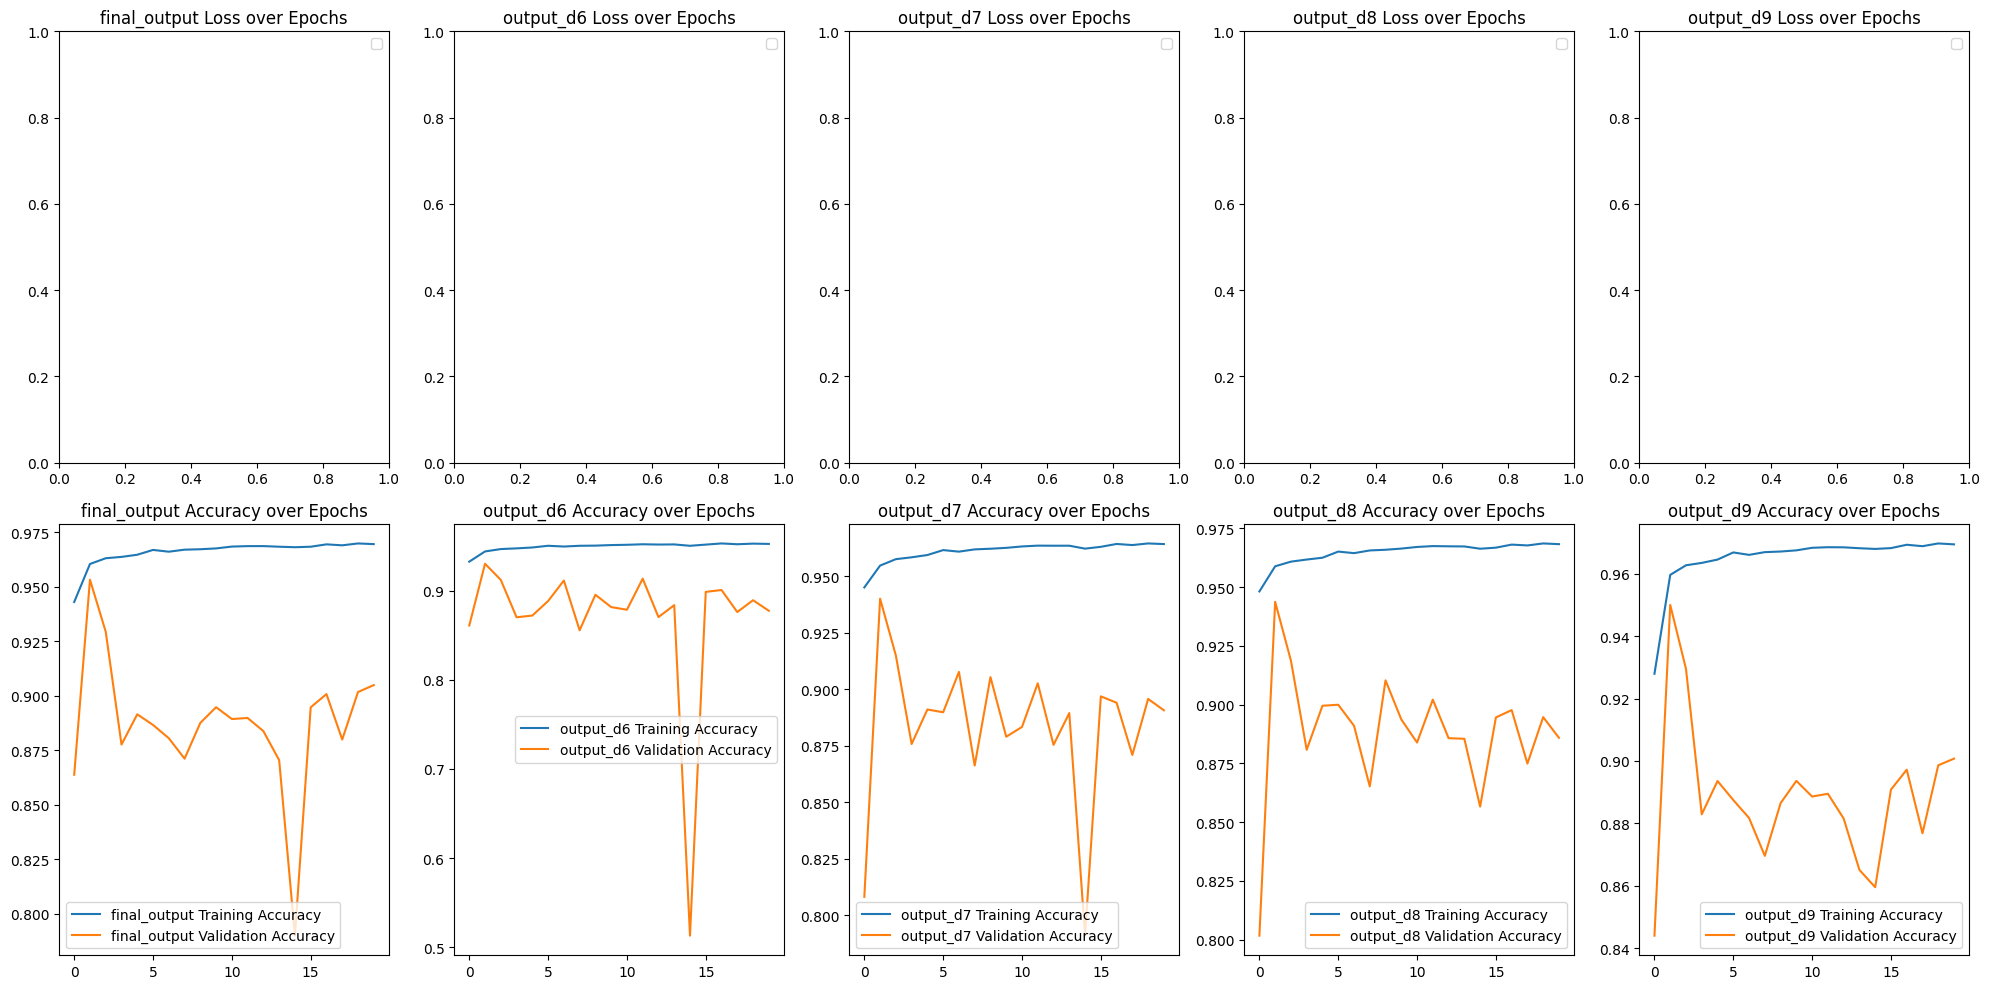

In [11]:
# CELL 11
# WORKING CODE

# Print the available keys in history.history
print("Available keys in history.history:")
print(history.history.keys())

# Plot loss and accuracy for each output
outputs = ['final_output', 'output_d6', 'output_d7', 'output_d8', 'output_d9']
plt.figure(figsize=(20, 10))

for i, output_name in enumerate(outputs):
    plt.subplot(2, 5, i+1)
    train_loss_key = f'{output_name}_loss'
    val_loss_key = f'val_{output_name}_loss'
    if train_loss_key in history.history:
        plt.plot(history.history[train_loss_key], label=f'{output_name} Training Loss')
    else:
        print(f"{train_loss_key} not found in history.history")
    if val_loss_key in history.history:
        plt.plot(history.history[val_loss_key], label=f'{output_name} Validation Loss')
    else:
        print(f"{val_loss_key} not found in history.history")
    plt.legend()
    plt.title(f'{output_name} Loss over Epochs')
    
    plt.subplot(2, 5, i+6)
    train_acc_key = f'{output_name}_accuracy'
    val_acc_key = f'val_{output_name}_accuracy'
    if train_acc_key in history.history:
        plt.plot(history.history[train_acc_key], label=f'{output_name} Training Accuracy')
    else:
        print(f"{train_acc_key} not found in history.history")
    if val_acc_key in history.history:
        plt.plot(history.history[val_acc_key], label=f'{output_name} Validation Accuracy')
    else:
        print(f"{val_acc_key} not found in history.history")
    plt.legend()
    plt.title(f'{output_name} Accuracy over Epochs')

plt.tight_layout()
plt.show()


In [12]:
# CELL 13: Compute IoU on Validation Set
# WORKING CODE 
from sklearn.metrics import accuracy_score, jaccard_score

# Predict on validation data
val_predictions = model.predict(X_val)

# Extract the final output prediction
val_predictions_final = val_predictions[0]  # Assuming final_output is the first output

# Convert predictions to class labels
val_predictions_labels = np.argmax(val_predictions_final, axis=-1)
Y_val_labels = np.argmax(Y_val, axis=-1)

# Flatten the arrays
val_predictions_flat = val_predictions_labels.flatten()
Y_val_flat = Y_val_labels.flatten()

# Compute metrics
accuracy = accuracy_score(Y_val_flat, val_predictions_flat)
iou_score = jaccard_score(Y_val_flat, val_predictions_flat, average='macro')

print("Validation Accuracy:", accuracy)
print("Validation IoU Score:", iou_score)


17/17 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step 
Validation Accuracy: 0.9049305924880663
Validation IoU Score: 0.5687456292103432


In [13]:
# CELL 14
# WORKING CODE

from sklearn.metrics import accuracy_score, jaccard_score, classification_report, confusion_matrix

# Ensure that model is trained and predictions are generated for the test set
test_predictions = model.predict(X_test)

# Assuming final_output is the first output, extract the prediction for final output
test_predictions_final = test_predictions[0]  # Adjust if necessary for your model's outputs

# Convert predictions to class labels
test_predictions_labels = np.argmax(test_predictions_final, axis=-1)
Y_test_labels = np.argmax(Y_test, axis=-1)

# Flatten the arrays
test_predictions_flat = test_predictions_labels.flatten()
Y_test_flat = Y_test_labels.flatten()

# Compute metrics
accuracy = accuracy_score(Y_test_flat, test_predictions_flat)
iou_score = jaccard_score(Y_test_flat, test_predictions_flat, average='macro')
print("Test Accuracy:", accuracy)
print("Test IoU Score:", iou_score)

# Compute IoU for each class
class_iou_scores = jaccard_score(Y_test_flat, test_predictions_flat, average=None)
class_labels = np.unique(Y_test_flat)
for class_id, iou in zip(class_labels, class_iou_scores):
    print(f"IoU for class {class_id}: {iou}")

# Classification Report
report = classification_report(Y_test_flat, test_predictions_flat, labels=class_labels)
print("\nClassification Report:\n", report)

# Confusion Matrix (optional, but useful for multi-class problems)
conf_matrix = confusion_matrix(Y_test_flat, test_predictions_flat)
print("\nConfusion Matrix:\n", conf_matrix)


10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step 
Test Accuracy: 0.906032731508639
Test IoU Score: 0.5736608272838623
IoU for class 0: 0.8858995292101841
IoU for class 1: 0.6731049222513849
IoU for class 2: 0.16197803039001799

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94  15392458
           1       0.68      0.98      0.80   3797014
           2       0.18      0.67      0.28     12576

    accuracy                           0.91  19202048
   macro avg       0.62      0.85      0.67  19202048
weighted avg       0.93      0.91      0.91  19202048


Confusion Matrix:
 [[13675476  1716221      761]
 [   44353  3713744    38917]
 [      14     4098     8464]]


In [14]:
# CELL 15
def convert_mask_to_rgb(mask):
    if len(mask.shape) > 2:
        mask = np.argmax(mask, axis=-1)
    rgb_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    rgb_mask[mask == 0] = [0, 0, 0]        # Background (Black)
    # rgb_mask[mask == 1] = [128, 128, 128]  # Bone (Gray)
    rgb_mask[mask == 2] = [0, 0, 255]      # Cancer Hotspot (Red in BGR)
    # rgb_mask[mask == 3] = [0, 255, 0]      # Non-hotspot (Green)
    return rgb_mask



In [15]:
# CELL 16
# Specify the exact filenames you want to load
target_files = ['20.jpg', '32.jpg', '61.jpg', '75.jpg', '111.jpg', '139.jpg', ]

# Initialize lists to hold images and masks
images = []
masks = []
loaded_filenames = []  # To keep track of loaded filenames

# Load only specified images and their corresponding masks
for file in target_files:
    # Load and resize image
    image_path = os.path.join(image_dir, file)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read image {file}, skipping.")
        continue
    # Resize image: cv2.resize expects (width, height)
    image = cv2.resize(image, (img_width, img_height))
    image = image / 255.0  # Normalize image

    # Construct mask filename
    base_filename = os.path.splitext(file)[0]
    mask_filename = base_filename + '_colored_mask.npy'
    mask_path = os.path.join(mask_dir, mask_filename)
    if not os.path.exists(mask_path):
        print(f"Mask not found for image {file}, skipping.")
        continue

    # Load and resize mask
    mask = np.load(mask_path)
    mask = cv2.resize(mask, (img_width, img_height), interpolation=cv2.INTER_NEAREST)

    # Convert mask to one-hot encoding
    mask_one_hot = np.zeros((img_height, img_width, num_classes), dtype=np.uint8)
    for i in range(num_classes):
        mask_one_hot[..., i] = (mask == i).astype(np.uint8)

    images.append(image)
    masks.append(mask_one_hot)
    loaded_filenames.append(file)  # Keep track of the filename

# Convert lists to NumPy arrays
images = np.array(images)
masks = np.array(masks)

# Print the shapes
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)
print("Loaded filenames:", loaded_filenames)  # List of loaded filenames to confirm




Images shape: (6, 512, 128, 3)
Masks shape: (6, 512, 128, 3)
Loaded filenames: ['20.jpg', '32.jpg', '61.jpg', '75.jpg', '111.jpg', '139.jpg']


Loading best weights from: /kaggle/working/unetplusplus_best.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Unique labels in predicted mask for 20.jpg: [0 1 2]


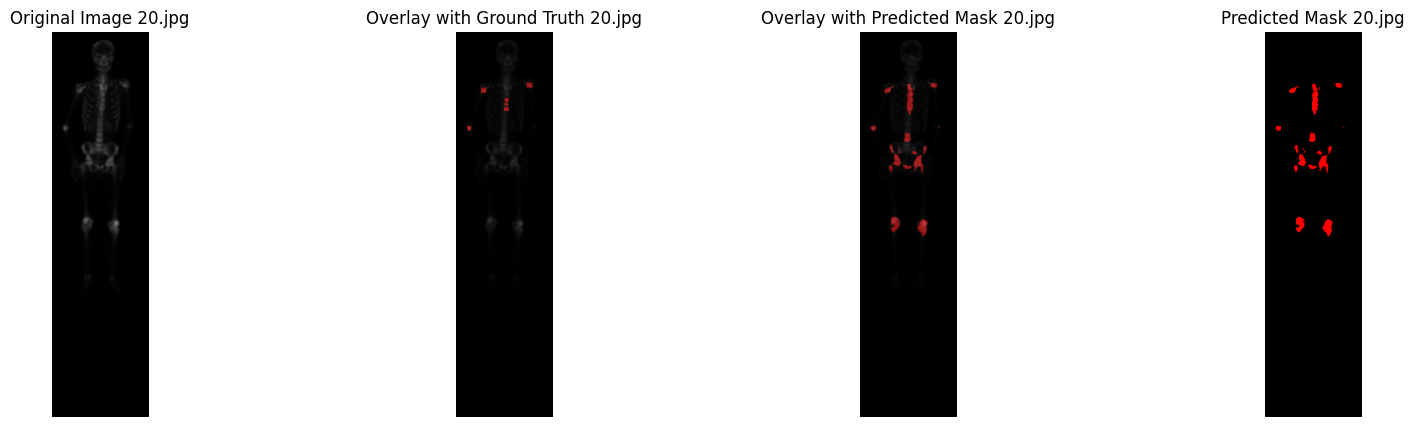

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Unique labels in predicted mask for 32.jpg: [0 1 2]


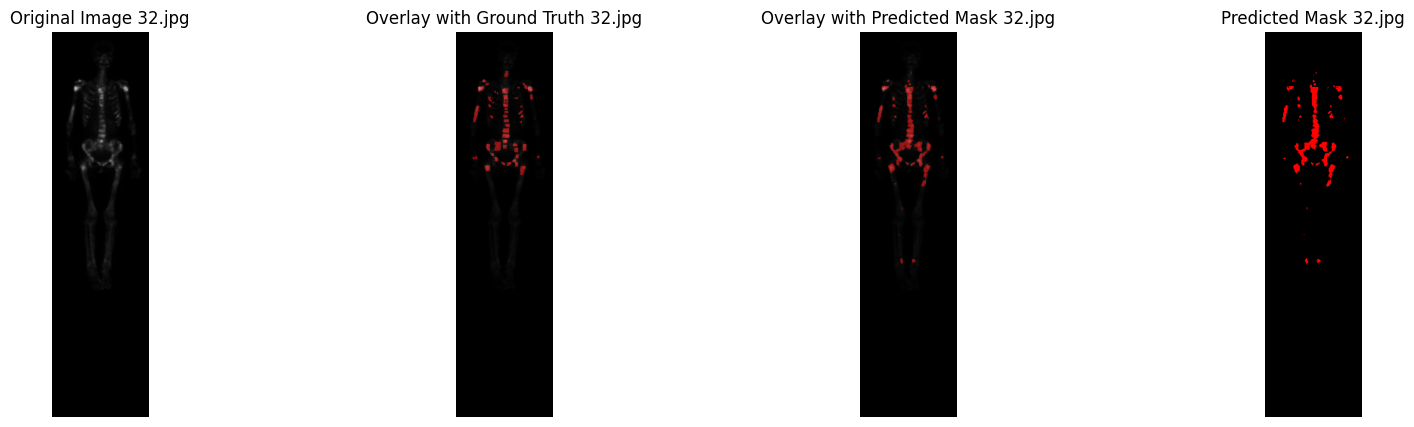

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Unique labels in predicted mask for 61.jpg: [0 1 2]


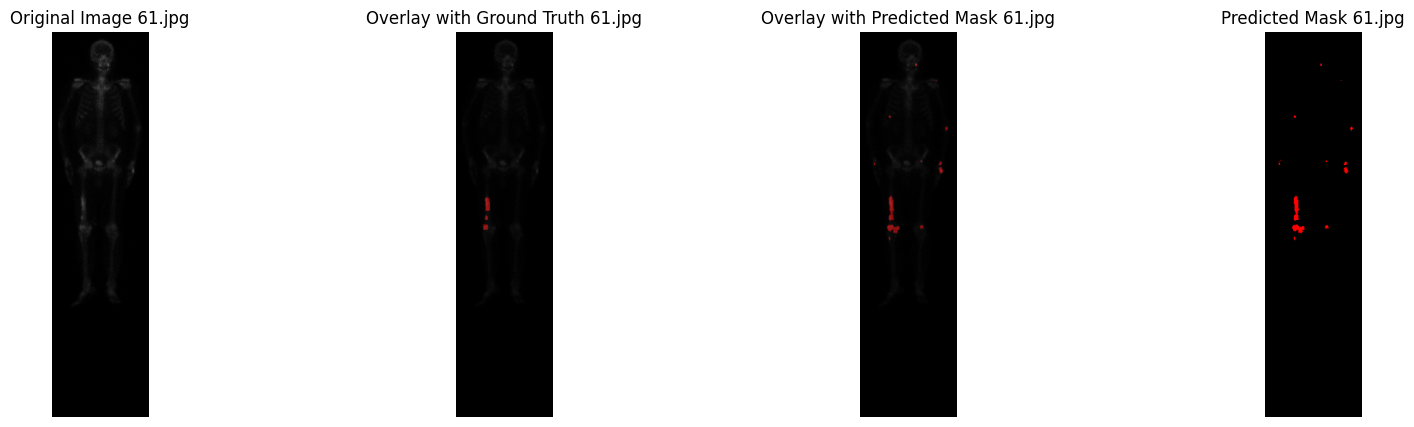

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Unique labels in predicted mask for 75.jpg: [0 1 2]


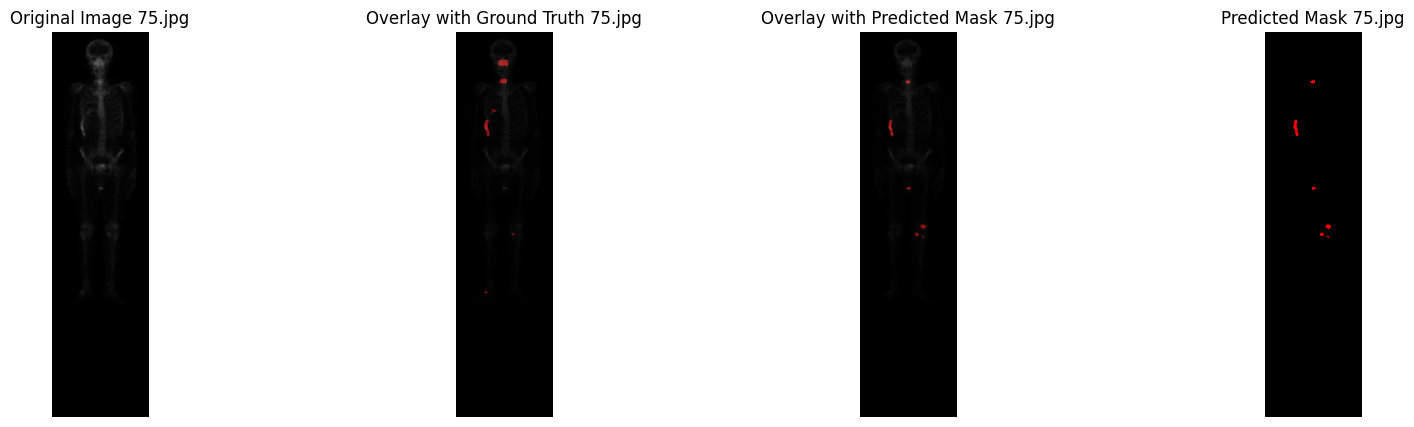

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Unique labels in predicted mask for 111.jpg: [0 1 2]


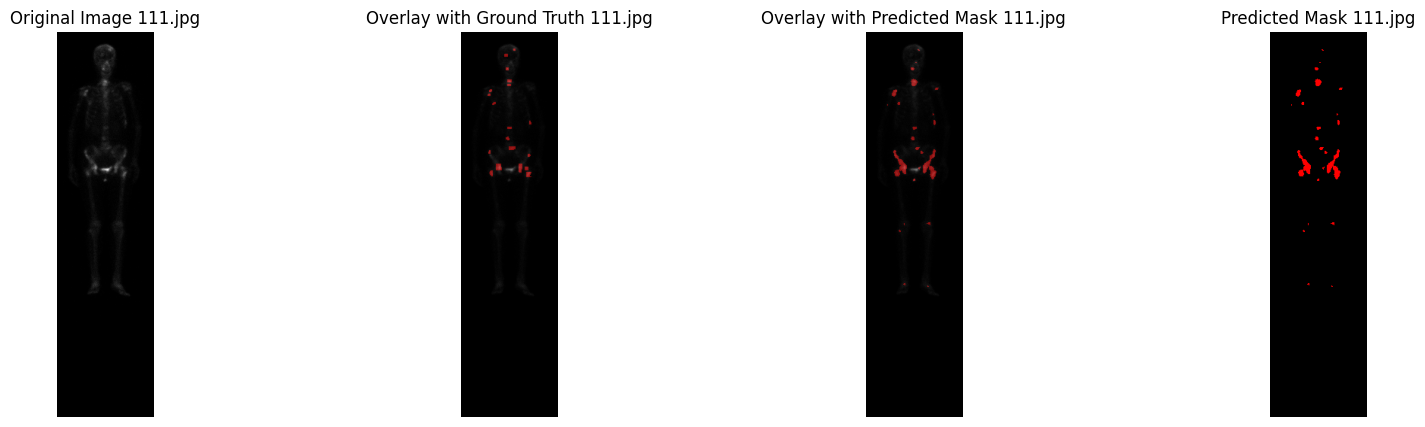

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Unique labels in predicted mask for 139.jpg: [0 1 2]


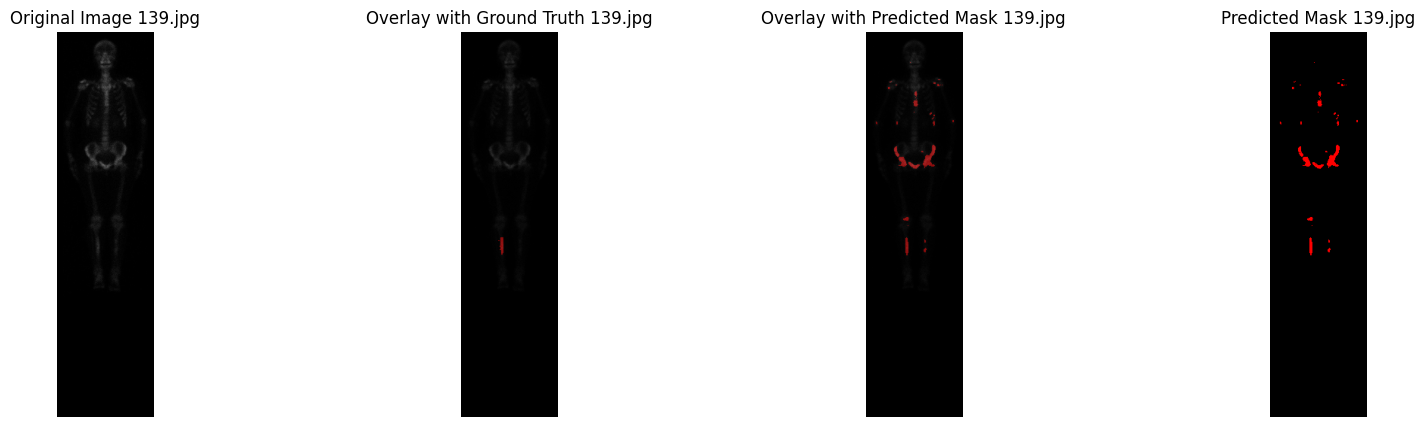

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Unique labels in predicted mask for 143.jpg: [0 1 2]


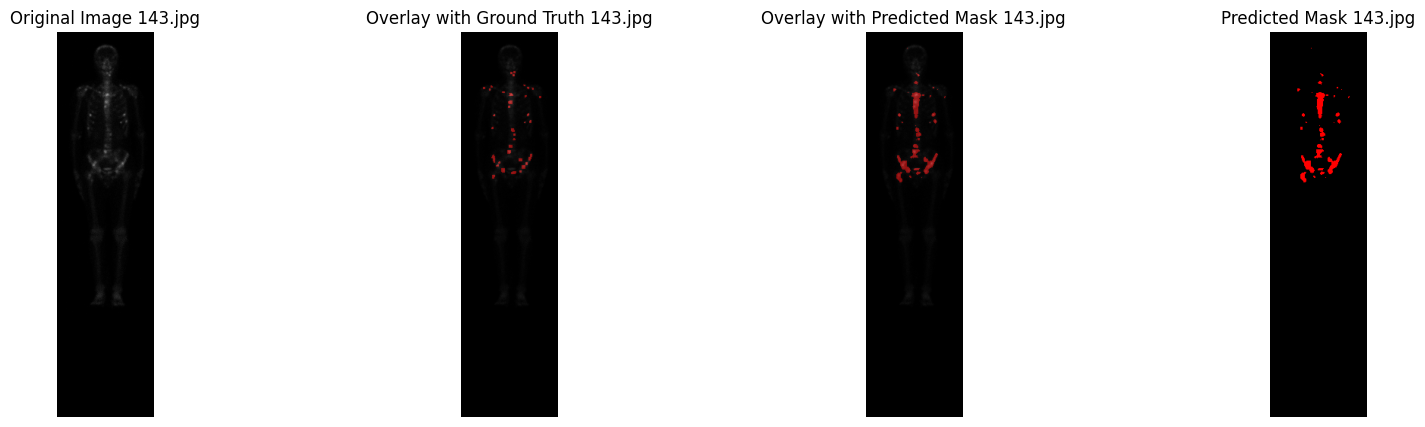

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Unique labels in predicted mask for 158.jpg: [0 1 2]


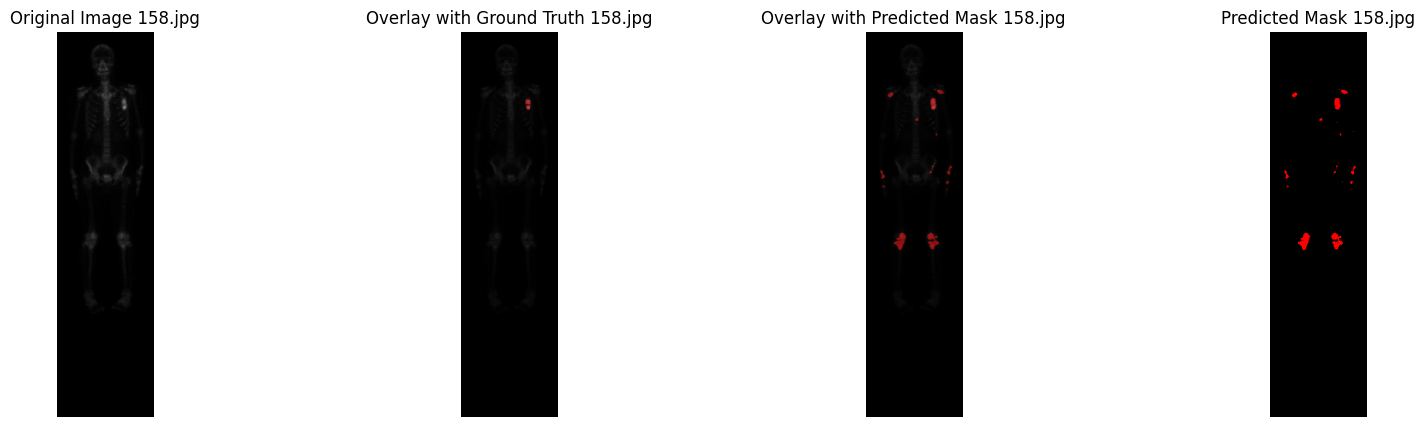

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Unique labels in predicted mask for 177.jpg: [0 1 2]


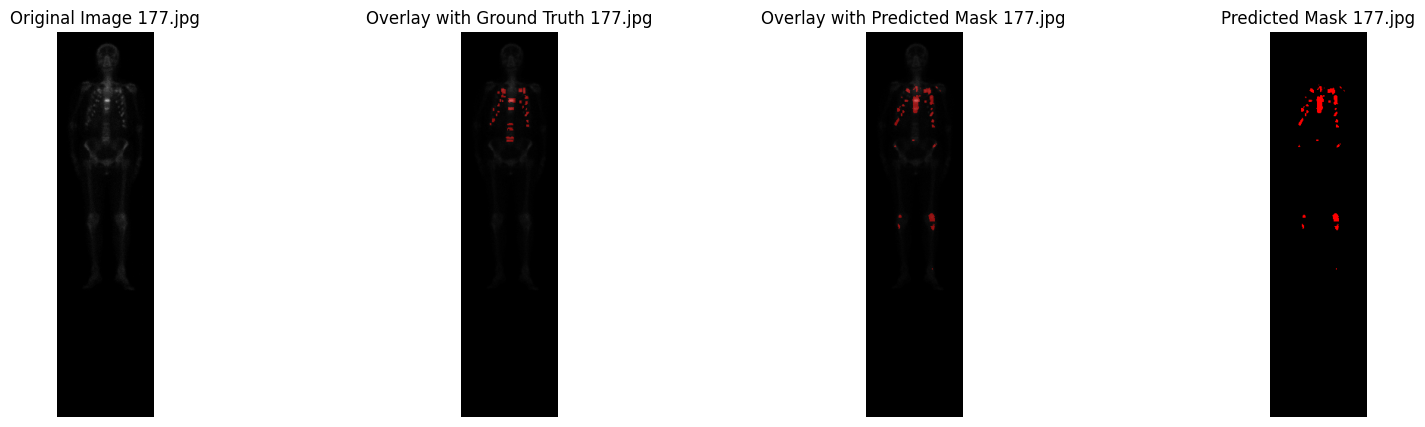

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Unique labels in predicted mask for 182.jpg: [0 1 2]


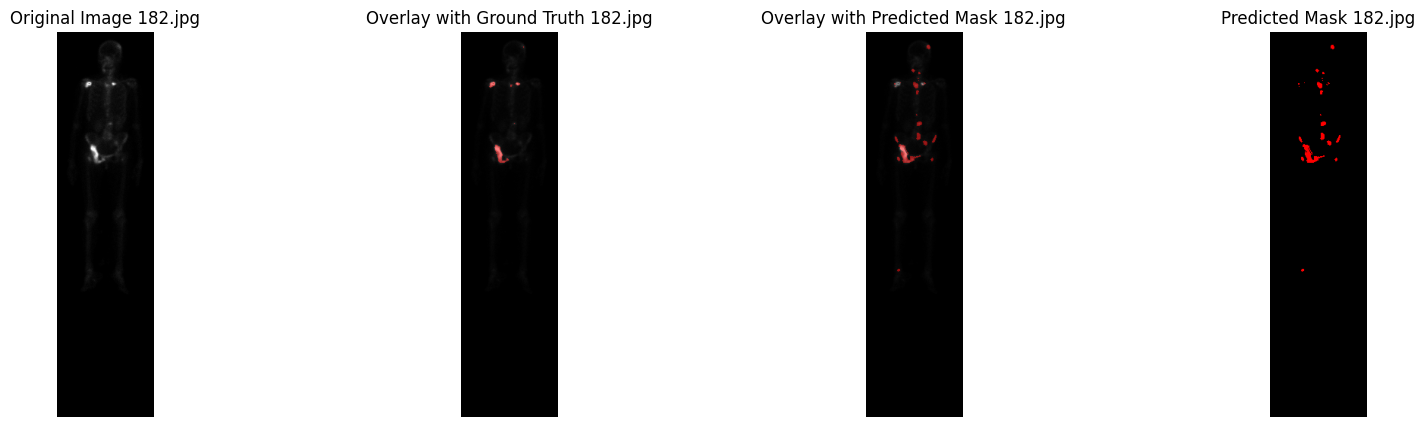

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Unique labels in predicted mask for 283.jpg: [0 1 2]


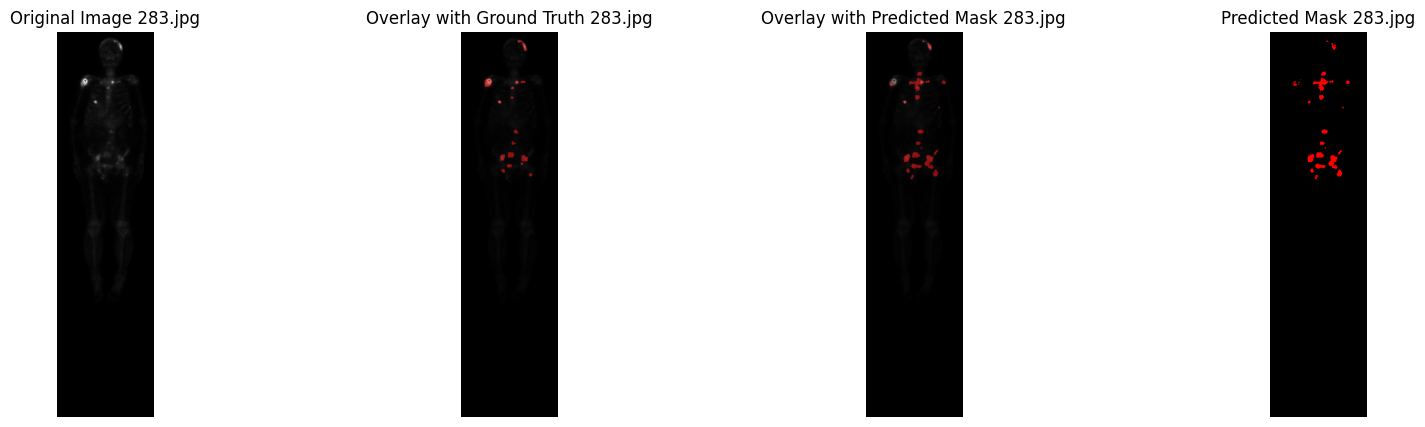

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Unique labels in predicted mask for 301.jpg: [0 1 2]


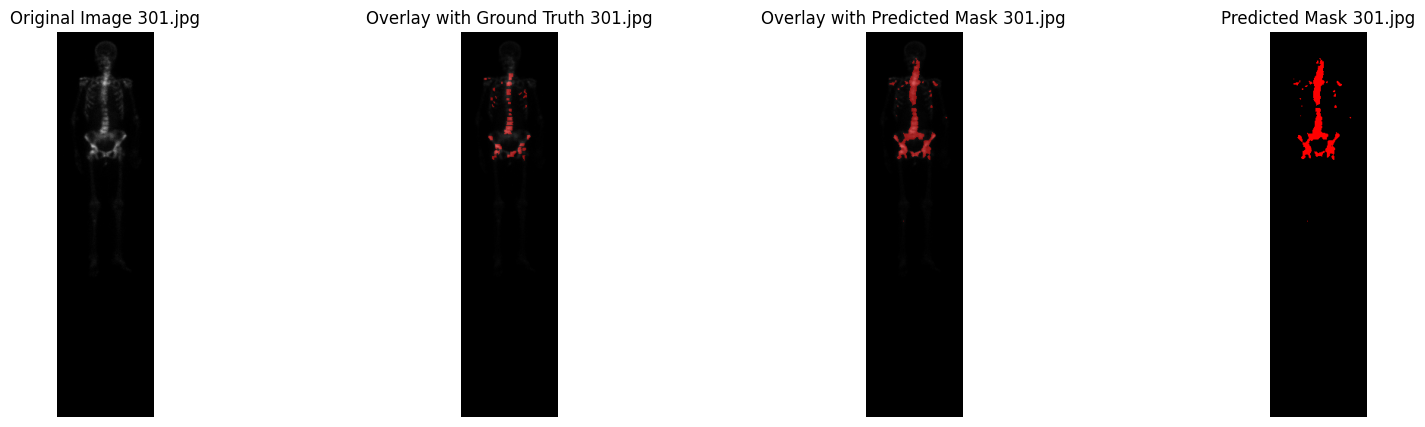

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Unique labels in predicted mask for 318.jpg: [0 1 2]


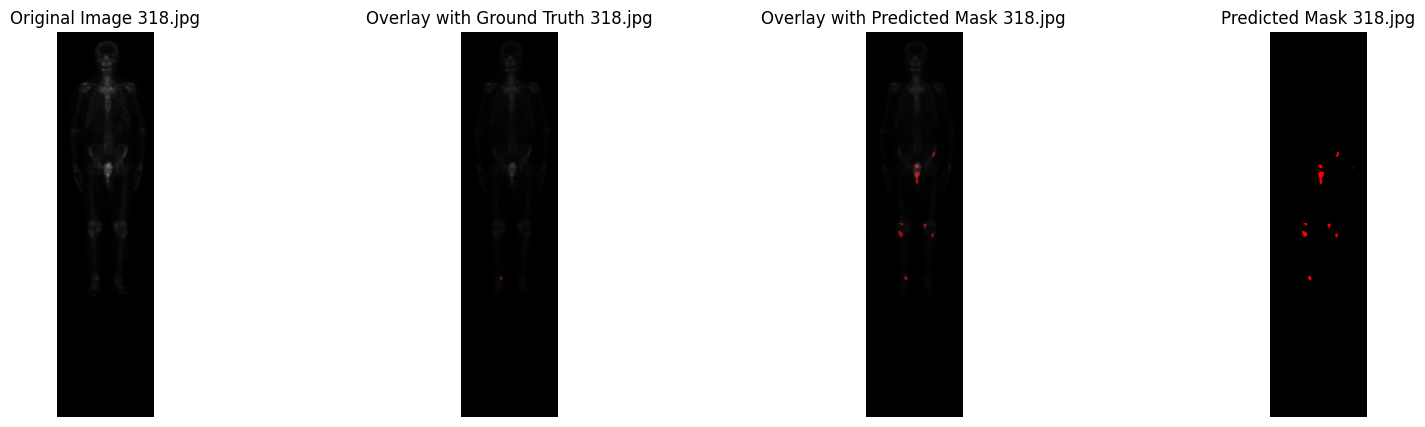

In [16]:
# CELL 17
# WORKING CODE


# List of filenames to test
filenames = ["20.jpg", "32.jpg", "61.jpg", "75.jpg", "111.jpg", "139.jpg", "143.jpg", "158.jpg", "177.jpg", "182.jpg", "283.jpg", "301.jpg", "318.jpg"]

def overlay_mask(image, mask_rgb, alpha=0.5):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    if mask_rgb.dtype != np.uint8:
        mask_rgb = mask_rgb.astype(np.uint8)
    
    # Ensure both have 3 channels
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    if len(mask_rgb.shape) == 2:
        mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_GRAY2BGR)

    # Ensure the shapes match
    if image.shape != mask_rgb.shape:
        height, width = image.shape[:2]
        mask_rgb = cv2.resize(mask_rgb, (width, height), interpolation=cv2.INTER_NEAREST)
    
    overlay = cv2.addWeighted(mask_rgb, alpha, image, 1 - alpha, 0)
    return overlay

def convert_mask_to_rgb(mask):
    if len(mask.shape) > 2:
        mask = np.argmax(mask, axis=-1)
    rgb_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    rgb_mask[mask == 0] = [0, 0, 0]        # Background (Black)
    # rgb_mask[mask == 1] = [128, 128, 128]  # Bone (Gray)
    rgb_mask[mask == 2] = [0, 0, 255]      # Cancer Hotspot (Red in BGR)
    # rgb_mask[mask == 3] = [0, 255, 0]      # Non-hotspot (Green)
    return rgb_mask

def display_image(image, title):
    """
    Converts an image from BGR to RGB and displays it using Matplotlib.
    
    Parameters:
    - image: The image to display (in BGR format).
    - title: The title of the plot.
    """
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.title(title)
    plt.axis('off')

# Load the best weights
weights_file = os.path.join(checkpoint_dir, "unetplusplus_best.weights.h5")
if os.path.exists(weights_file):
    print("Loading best weights from:", weights_file)
    model.load_weights(weights_file)
else:
    print("No weights files found. Please check your checkpoint directory.")

# Predict and display results
for filename in filenames:
    # Load image in color mode
    image_path = os.path.join(image_dir, filename)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        print(f"Image {filename} not found, skipping.")
        continue

    # Resize and normalize image
    image_resized = cv2.resize(image, (img_width, img_height))
    image_normalized = image_resized / 255.0  # Normalize for prediction
    
    # Load ground truth mask
    mask_filename = filename.split('.')[0] + '_colored_mask.npy'
    mask_path = os.path.join(mask_dir, mask_filename)
    if not os.path.exists(mask_path):
        print(f"Mask for {filename} not found, skipping.")
        continue
    mask = np.load(mask_path)
    mask = cv2.resize(mask, (img_width, img_height), interpolation=cv2.INTER_NEAREST)
    
    # Convert ground truth mask to RGB and create overlay
    mask_rgb_gt = convert_mask_to_rgb(mask)
    overlay_gt = overlay_mask(image_resized, mask_rgb_gt, alpha=0.5)
    if overlay_gt is None:
        print(f"Error creating overlay for ground truth of {filename}, skipping.")
        continue

    # Perform prediction
    predictions = model.predict(image_normalized[np.newaxis, ...])  # Add batch dimension
    
    # Extract the final output prediction
    pred_mask_probs = predictions[0][0]  # Get the first prediction and remove batch dimension
    pred_mask = np.argmax(pred_mask_probs, axis=-1)
    print(f"Unique labels in predicted mask for {filename}:", np.unique(pred_mask))
    
    # Convert predicted mask to RGB and create overlay
    mask_rgb_pred = convert_mask_to_rgb(pred_mask)
    overlay_pred = overlay_mask(image_resized, mask_rgb_pred, alpha=0.5)
    if overlay_pred is None:
        print(f"Error creating overlay for prediction of {filename}, skipping.")
        continue

    # Plot the results
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    display_image(image_resized, f'Original Image {filename}')

    plt.subplot(1, 4, 2)
    display_image(overlay_gt, f'Overlay with Ground Truth {filename}')

    plt.subplot(1, 4, 3)
    display_image(overlay_pred, f'Overlay with Predicted Mask {filename}')

    plt.subplot(1, 4, 4)
    display_image(mask_rgb_pred, f'Predicted Mask {filename}')

    plt.show()




In [17]:
from tensorflow.keras.models import load_model

# Pastikan Anda mendefinisikan kembali fungsi loss dan metric kustom
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np

# Definisikan kembali atau muat ulang class_weights
# Jika Anda menggunakan class_weights yang sama seperti saat training
class_weights = np.array([0.5, 1.0, 5.0, 5.0])  # Sesuaikan sesuai dengan yang digunakan saat training

def focal_loss(gamma=2., alpha=class_weights):
    alpha = K.constant(alpha, dtype=tf.float32)
    gamma = float(gamma)

    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=-1)

    return focal_loss_fixed

def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    smooth = 1e-6
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def combined_loss(y_true, y_pred):
    return focal_loss()(y_true, y_pred) + dice_loss(y_true, y_pred)

# Implementasi metric IoU
def iou_metric(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = K.argmax(y_true, axis=-1)
    intersection = K.sum(K.cast(y_true * y_pred, 'float32') * K.cast(y_pred, 'float32'))
    union = K.sum(K.cast(y_true, 'float32') + K.cast(y_pred, 'float32')) - intersection
    return intersection / (union + K.epsilon())

# Definisikan custom objects untuk memuat model
custom_objects = {
    'combined_loss': combined_loss,
    'iou_metric': iou_metric
}

# Path model yang disimpan
model_path = '/kaggle/working/unetplusplus_final.h5'

# Memuat model
model = load_model(model_path, custom_objects=custom_objects)

print(f"Model berhasil dimuat dari {model_path}")



Model berhasil dimuat dari /kaggle/working/unetplusplus_final.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 582ms/step
Test Accuracy: 0.906032731508639


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Mean IoU Score: 0.4302456204628967


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


IoU for class 0: 0.8858995292101841
IoU for class 1: 0.6731049222513849
IoU for class 2: 0.16197803039001799
IoU for class 3: 0.0


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94  15392458
           1       0.68      0.98      0.80   3797014
           2       0.18      0.67      0.28     12576
           3       0.00      0.00      0.00         0

   micro avg       0.91      0.91      0.91  19202048
   macro avg       0.46      0.63      0.51  19202048
weighted avg       0.93      0.91      0.91  19202048



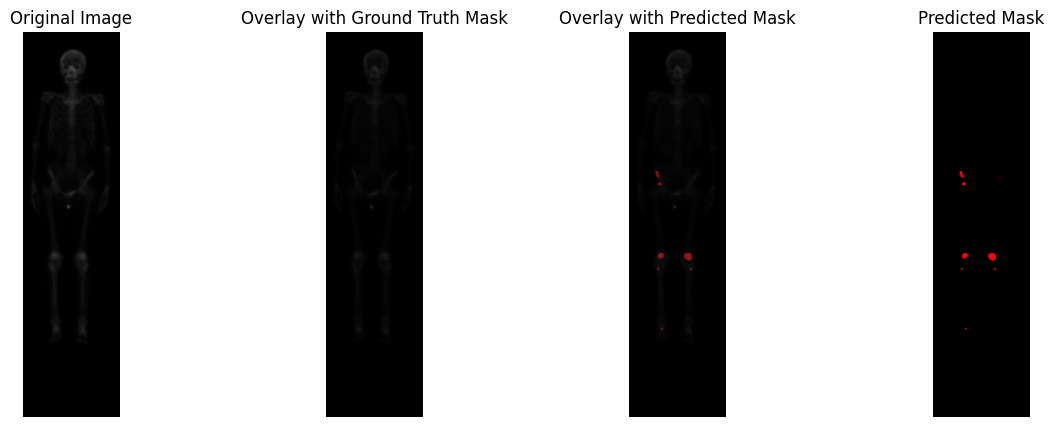

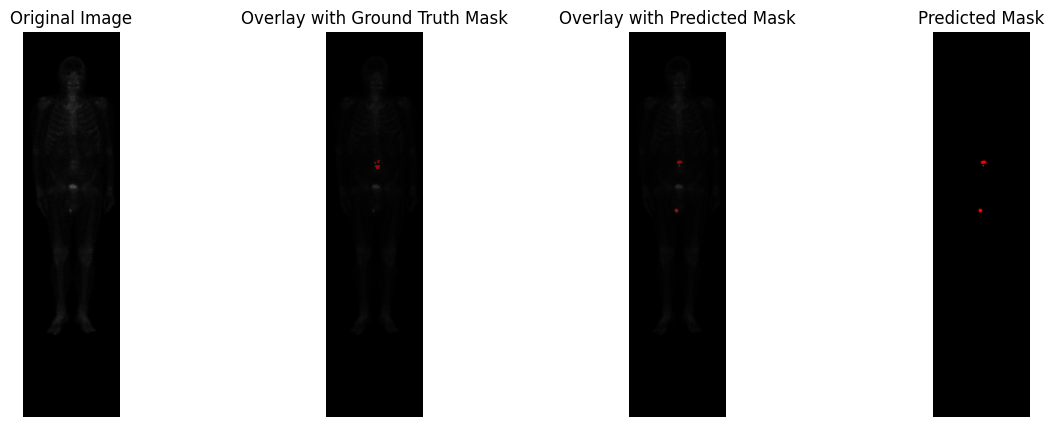

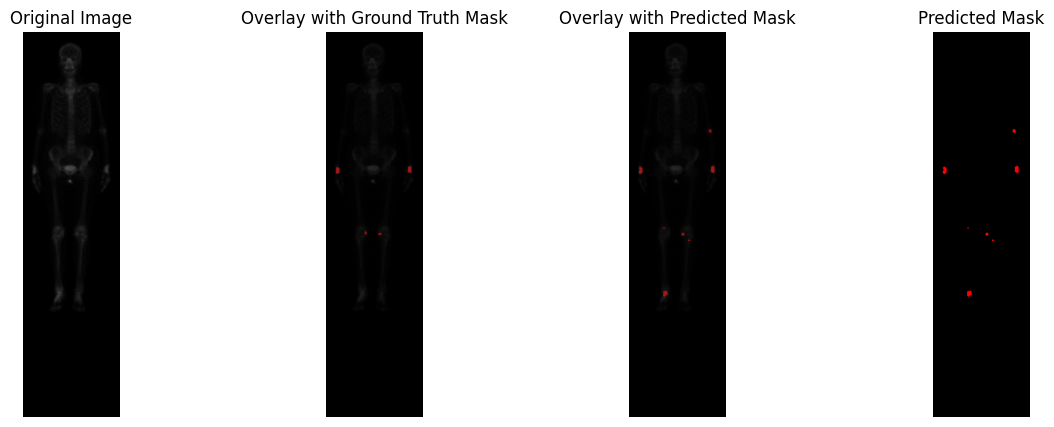

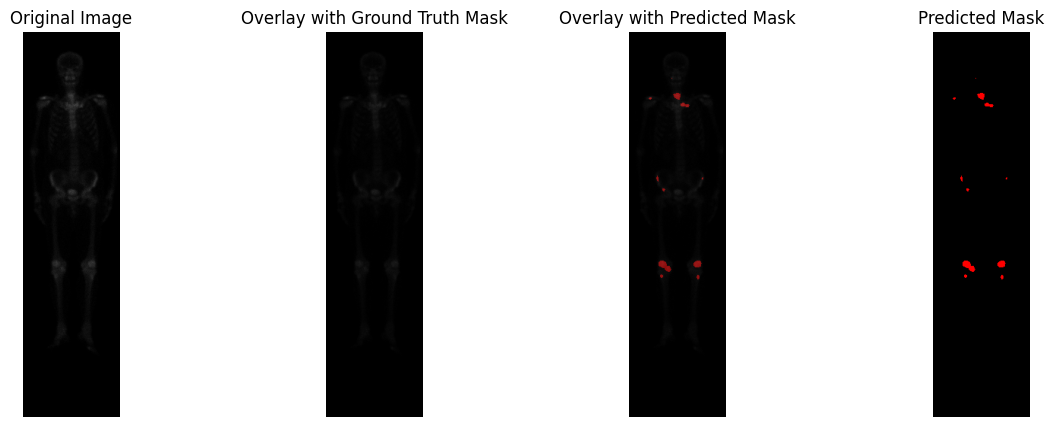

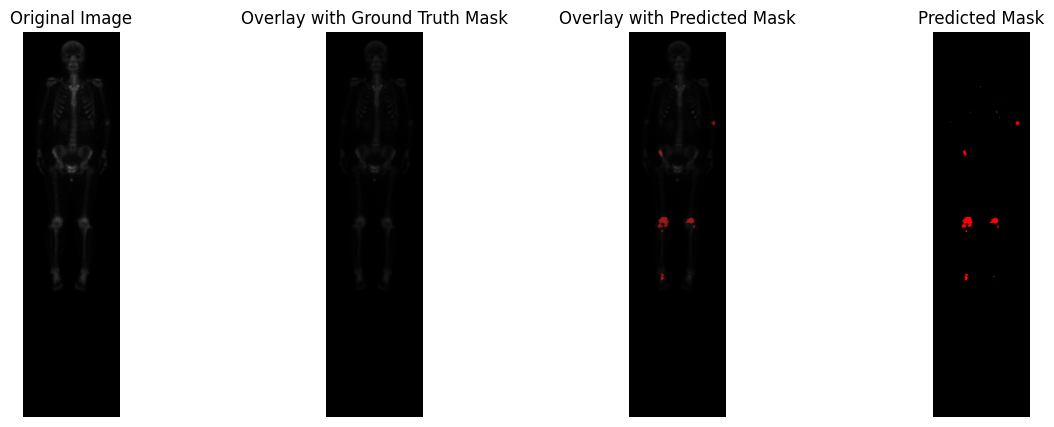

In [18]:
# CELL 19

# Assuming you have already loaded the model in CELL 18
# and you have X_test and Y_test from CELL 4

# Predict on test data
test_predictions = model.predict(X_test)

# Extract the final output prediction
test_predictions_final = test_predictions[0]  # Assuming 'final_output' is the first output

# Convert predictions to class labels
test_predictions_labels = np.argmax(test_predictions_final, axis=-1)
Y_test_labels = np.argmax(Y_test, axis=-1)

# Flatten the arrays for metric computation
test_predictions_flat = test_predictions_labels.flatten()
Y_test_flat = Y_test_labels.flatten()

# Compute metrics
from sklearn.metrics import accuracy_score, jaccard_score, classification_report

class_labels = [0, 1, 2, 3]

# Compute Accuracy
accuracy = accuracy_score(Y_test_flat, test_predictions_flat)
print("Test Accuracy:", accuracy)

# Compute Mean IoU
iou_score = jaccard_score(Y_test_flat, test_predictions_flat, average='macro', labels=class_labels)
print("Mean IoU Score:", iou_score)

# Compute IoU for each class
class_iou_scores = jaccard_score(Y_test_flat, test_predictions_flat, average=None, labels=class_labels)
for class_id, iou in zip(class_labels, class_iou_scores):
    print(f"IoU for class {class_id}: {iou}")

# Classification Report
report = classification_report(Y_test_flat, test_predictions_flat, labels=class_labels)
print("\nClassification Report:\n", report)

# Optionally, display some test images with their predicted masks
import random
import matplotlib.pyplot as plt

num_samples = 5  # Number of test samples to display
indices = random.sample(range(len(X_test)), num_samples)

for idx in indices:
    image = X_test[idx]
    true_mask = Y_test_labels[idx]
    pred_mask = test_predictions_labels[idx]
    
    # Convert masks to RGB
    true_mask_rgb = convert_mask_to_rgb(true_mask)
    pred_mask_rgb = convert_mask_to_rgb(pred_mask)
    
    # Original image (rescale for display)
    image_disp = (image * 255).astype(np.uint8)
    
    # Overlays
    overlay_true = overlay_mask(image_disp, true_mask_rgb, alpha=0.5)
    overlay_pred = overlay_mask(image_disp, pred_mask_rgb, alpha=0.5)
    
    # Plot the results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 4, 1)
    display_image(image_disp, 'Original Image')
    
    plt.subplot(1, 4, 2)
    display_image(overlay_true, 'Overlay with Ground Truth Mask')
    
    plt.subplot(1, 4, 3)
    display_image(overlay_pred, 'Overlay with Predicted Mask')
    
    plt.subplot(1, 4, 4)
    display_image(pred_mask_rgb, 'Predicted Mask')
    
    plt.show()

